# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подключение библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

### Загрузка данных

In [4]:
data = pd.read_csv('datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


__Признаки__

* DateCrawled — дата скачивания анкеты из базы

* VehicleType — тип автомобильного кузова

* RegistrationYear — год регистрации автомобиля

* Gearbox — тип коробки передач

* Power — мощность (л. с.)

* Model — модель автомобиля

* Kilometer — пробег (км)

* RegistrationMonth — месяц регистрации автомобиля

* FuelType — тип топлива

* Brand — марка автомобиля

* Repaired — была машина в ремонте или нет

* DateCreated — дата создания анкеты

* NumberOfPictures — количество фотографий автомобиля

* PostalCode — почтовый индекс владельца анкеты (пользователя)

* LastSeen — дата последней активности пользователя

__Целевой признак__
* Price — цена (евро)

### Обработка пропусков

In [5]:
print('Процент пропусков:')
data.isnull().sum() / len(data) * 100

Процент пропусков:


DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [6]:
data.shape

(354369, 16)

In [7]:
columns_to_fill = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
data[columns_to_fill] = data[columns_to_fill].apply(lambda x: x.fillna(x.mode()[0]))

In [8]:
print('Процент пропусков:')
data.isnull().sum() / len(data) * 100

Процент пропусков:


DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

### Типы данных

In [9]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

In [10]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


### Дубликаты

In [11]:
print(f'Кол-во дубликатов: {data.duplicated().sum()}')

Кол-во дубликатов: 5


In [12]:
data = data.drop_duplicates()  
print(f'Кол-во дубликатов: {data.duplicated().sum()}')

Кол-во дубликатов: 0


In [13]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(data[col].unique())

['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto']
['golf' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's

In [14]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

In [15]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

### Исследовательский анализ данных

In [16]:
def build_hist(df, bins=30):
    columns = df.select_dtypes(include='number').columns
    for col in columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col].dropna(), color='#3785D8', kde=False, bins=bins)
        sns.despine()
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

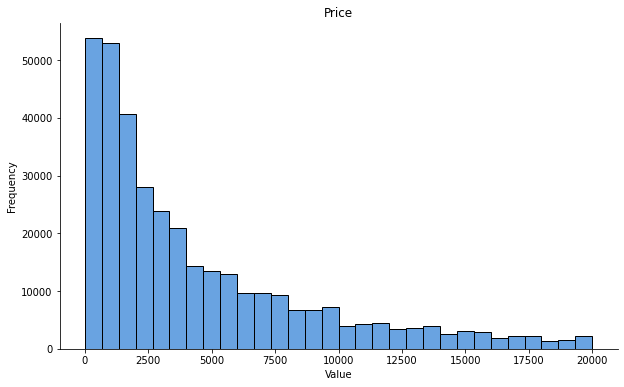

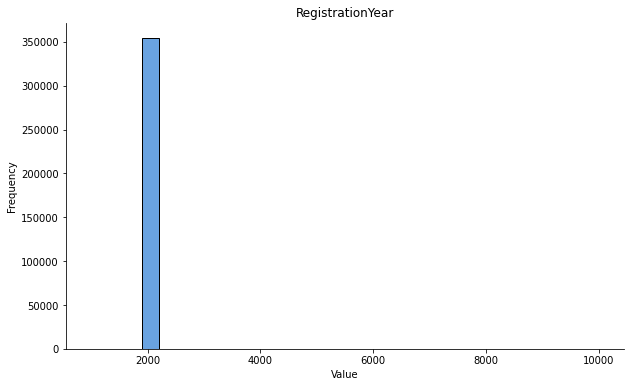

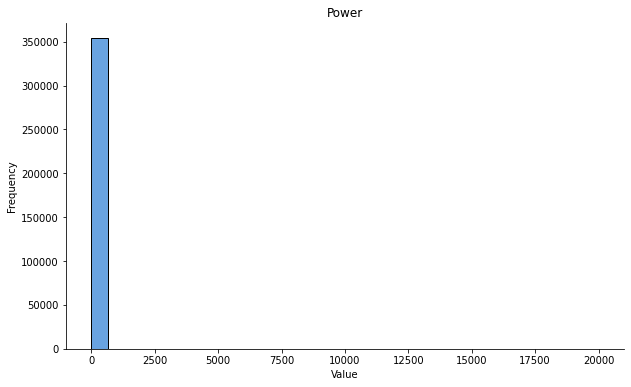

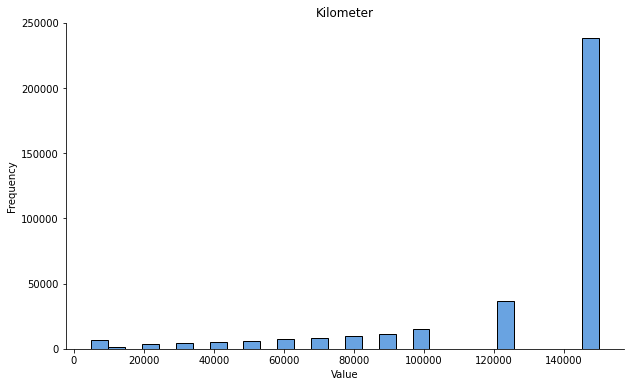

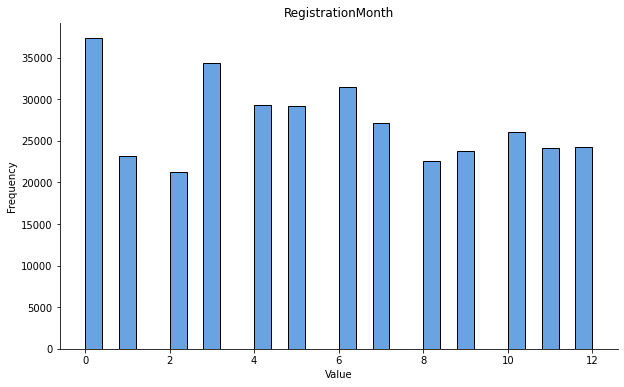

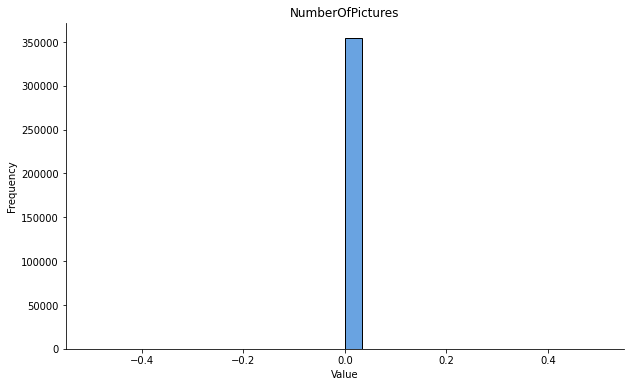

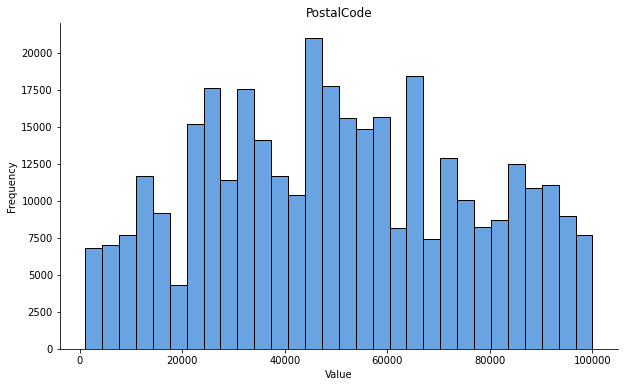

In [17]:
build_hist(data)

С ростом цены количество машин стремительно увеличивается. Видим, наибольшее количество с ценой 0 - на это нужно обратить внимание. Количество фотографий машин везде 0 - следует удалить этот признак. Некоторые машины имеют нулевой месяц регистрации


In [18]:
def build_plots(df):
    columns = df.select_dtypes(include='object').columns.tolist()
    columns.remove('Model')
    for col in columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=col, palette='viridis')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

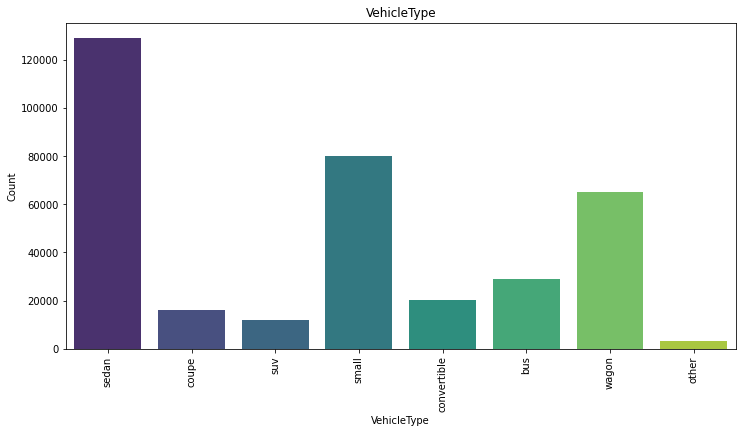

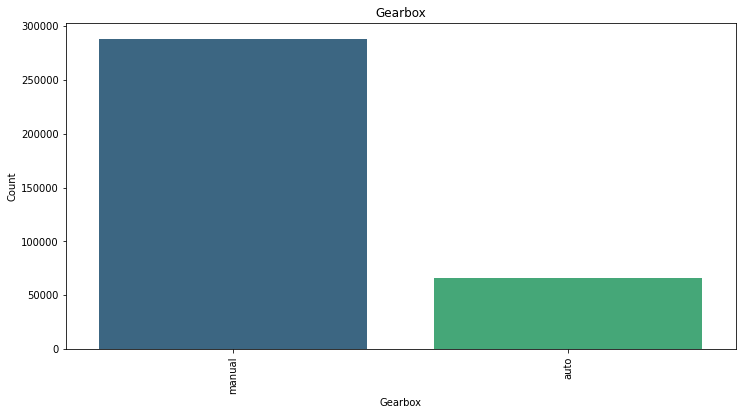

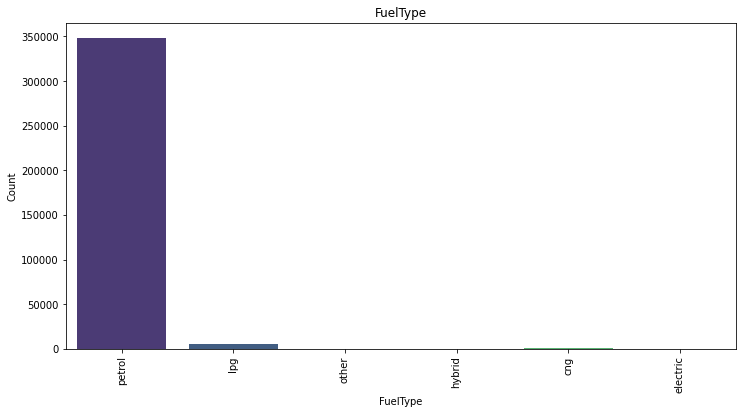

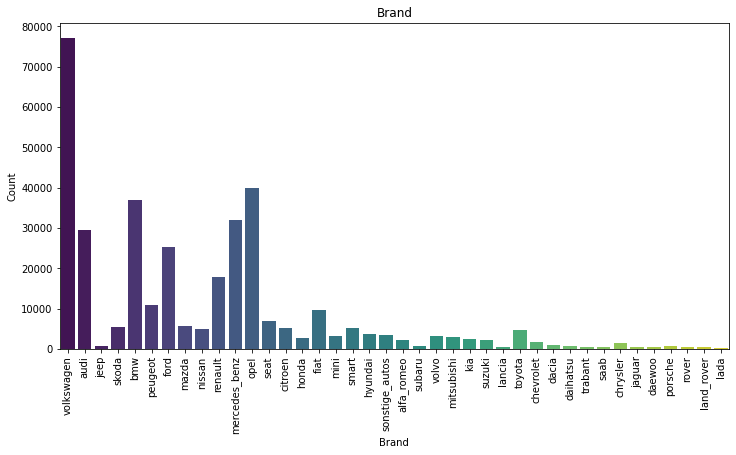

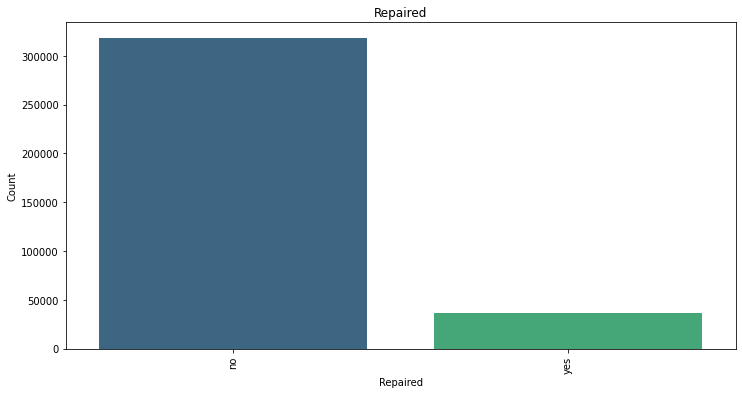

In [19]:
build_plots(data)

Седан - наиболее распространенный тип кузова в данных. Количество машин с ручной коробкой передач сильно превышает количество с автоматической. Большинство машин на бензине. Audi и Volkswagen - наиболее распространенные марки машин в датасете

In [20]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [21]:
lower = data['Price'].quantile(0.05)
data = data[data['Price'] > lower]

In [22]:
data = data[(data['RegistrationYear'] < 2017) & (data['RegistrationYear'] > 1980)]

In [23]:
mode = data['RegistrationMonth'][data['RegistrationMonth'] != 0].mode()[0]
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, mode)

In [24]:
lower = data['Power'].quantile(0.1)
upper = data['Power'].quantile(0.99)
data = data[(data['Power'] > lower) & (data['Power'] < upper)]

Удалим неинформативные признаки

In [25]:
data = data.drop(['DateCrawled', 'NumberOfPictures', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [26]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,281817.000000,281817.000000,281817.000000,281817.000000
mean,4891.631392,2003.235412,120.396811,128491.396899
std,4545.018832,5.799521,48.008316,36452.887548
min,202.000000,1981.000000,46.000000,5000.000000
25%,1449.000000,1999.000000,80.000000,125000.000000
50%,3250.000000,2003.000000,115.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,303.000000,150000.000000


### Корреляционный анализ

In [27]:
corr = data.corr(method='spearman')
corr.style.background_gradient(cmap='viridis')

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.692336,0.506113,-0.384249
RegistrationYear,0.692336,1.000000,0.159803,-0.420880
Power,0.506113,0.159803,1.000000,0.120428
Kilometer,-0.384249,-0.420880,0.120428,1.000000


Сильной корреляции между признаками не наблюдаем

## Обучение моделей

### CatBoost

In [28]:
X = data.drop('Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
cat_features = data.select_dtypes(exclude='number').columns.tolist()

In [30]:
Cat_model = CatBoostRegressor(loss_function="RMSE", cat_features=cat_features, logging_level='Silent') 

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.4],
    'depth': [4, 6, 8],
    'iterations': [50, 100, 150]
}

grid_search = GridSearchCV(estimator=Cat_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=0)

In [31]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fece083c430>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [50, 100, 150],
                         'learning_rate': [0.01, 0.1, 0.2, 0.4]},
             scoring='neg_root_mean_squared_error')

In [32]:
print(f'RMSE лучшей модели CatBoost: {-grid_search.best_score_}')

RMSE лучшей модели CatBoost: 1558.4924921994564


In [33]:
Cat_model = grid_search.best_estimator_

In [34]:
best_index = grid_search.best_index_
mean_fit_time = grid_search.cv_results_['mean_fit_time'][best_index]
pred_time = grid_search.cv_results_['mean_score_time'][best_index]

In [35]:
print("Время обучения лучшей модели (секунды):", mean_fit_time)
print("Время предсказания лучшей модели (секунды):", pred_time)

Время обучения лучшей модели (секунды): 9.037674506505331
Время предсказания лучшей модели (секунды): 0.10101850827534993


In [36]:
models = pd.DataFrame({
    'model name': ['CatBoost'],
    'hyperparameters': [grid_search.best_params_],
    'RMSE': [round(-grid_search.best_score_, 2)],
    'training time (s)': [round(mean_fit_time, 2)],
    'prediction time (s)': [round(pred_time, 2)]
})

### LightGBM 

In [37]:
data_light = data.copy()

In [38]:
data_light[cat_features] = data_light[cat_features].astype('category')

In [39]:
X = data_light.drop('Price', axis=1)  
y = data_light['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [40]:
lgb_model = lgb.LGBMRegressor(objective='rmse')

param_grid = {
    'learning_rate': [0.1, 0.4],
    'num_leaves': [5, 10],
    'max_depth': [5, 10]
}

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2, n_jobs=-1, verbose=1)

In [41]:
grid_search.fit(X_train, y_train, categorical_feature=cat_features)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


GridSearchCV(cv=2, estimator=LGBMRegressor(objective='rmse'), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.4], 'max_depth': [5, 10],
                         'num_leaves': [5, 10]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [42]:
print(f'RMSE лучшей модели LightGBM: {-grid_search.best_score_}')

RMSE лучшей модели LightGBM: 1595.2483882799897


In [43]:
lgb_model = grid_search.best_estimator_
lgb_model

LGBMRegressor(learning_rate=0.4, max_depth=10, num_leaves=10, objective='rmse')

In [44]:
best_index = grid_search.best_index_
mean_fit_time = grid_search.cv_results_['mean_fit_time'][best_index]
pred_time = grid_search.cv_results_['mean_score_time'][best_index]

In [45]:
print("Время обучения лучшей модели (секунды):", mean_fit_time)
print("Время предсказания лучшей модели (секунды):", pred_time)

Время обучения лучшей модели (секунды): 2.5943031311035156
Время предсказания лучшей модели (секунды): 0.5989497900009155


In [46]:
new_row = {'model name': 'LightGBM', 
           'hyperparameters': grid_search.best_params_,
           'RMSE': round(-grid_search.best_score_, 2),
           'training time (s)': round(mean_fit_time, 2),
           'prediction time (s)': round(pred_time, 2)}
models.loc[1] = new_row

### DecisionTreeRegressor

In [47]:
X = data.drop('Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features) 
    ],
    remainder='passthrough'
)

In [49]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [50]:
param_grid = {
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [2, 4, 7]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=0)

In [51]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10, 20],
                         'model__min_samples_leaf': [2, 4, 7],
                         'model__min_samples_split': [5, 10, 15]},
             scoring='neg_root_mean_squared_error')

In [52]:
print(f'RMSE лучшей модели DecisionTreeRegressor: {-grid_search.best_score_}')

RMSE лучшей модели DecisionTreeRegressor: 1709.887806816574


In [53]:
tree_model = grid_search.best_estimator_
tree_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=20, min_samples_leaf=4,
                                       min_samples_split=15,
                                       random_state=42))])

In [54]:
best_index = grid_search.best_index_
mean_fit_time = grid_search.cv_results_['mean_fit_time'][best_index]
pred_time = grid_search.cv_results_['mean_score_time'][best_index]

In [55]:
print("Время обучения лучшей модели (секунды):", mean_fit_time)
print("Время предсказания лучшей модели (секунды):", pred_time)

Время обучения лучшей модели (секунды): 0.5284653504689535
Время предсказания лучшей модели (секунды): 0.11547430356343587


In [56]:
new_row = {'model name': 'DecisionTreeRegressor', 
           'hyperparameters': grid_search.best_params_,
           'RMSE': round(-grid_search.best_score_, 2),
           'training time (s)': round(mean_fit_time, 2),
           'prediction time (s)': round(pred_time, 2)}
models.loc[2] = new_row

## Анализ моделей

### Характеристики моделей

In [57]:
models.head()

,model name,hyperparameters,RMSE,training time (s),prediction time (ms)
0,CatBoost,"{'depth': 8, 'iterations': 150, 'learning_rate...",1558.49,9.04,0.10
1,LightGBM,"{'learning_rate': 0.4, 'max_depth': 10, 'num_l...",1595.25,2.59,0.60
2,DecisionTreeRegressor,"{'model__max_depth': 20, 'model__min_samples_l...",1709.89,0.53,0.12


### Вывод

* Все модели имеют RMSE меньше 2500
* У CatBoost наилучшая метрика - 1558.49
* Модель градиентого бустинга CatBoost имеет самую высокую скорость предсказания
* Дольше всех обучалась модель CatBoost (9.04s), быстрее - DecisionTreeRegressor (0.53s)

__Итог: наиболее оптимальная модель для заказчика - градиентный бустинг LightGBM__

## Предсказание на тестовой выборке

In [65]:
X_test[cat_features] = X_test[cat_features].astype('category')

In [66]:
pred = lgb_model.predict(X_test)

In [67]:
rmse = mean_squared_error(pred, y_test, squared=False)
print(f'Метрика лучшей модели на тестовой выборке: {rmse}')

Метрика лучшей модели на тестовой выборке: 1584.685713588735
